## Skin Cancer Classification


### Install dependencies

In [ ]:
!pip install -q datasets transformers
!pip install accelerate
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.7/211.7 kB 29.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ...

In [ ]:
#load libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
# Import the image processor compatible with the given model architecture
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import numpy as np
import torch
from datasets import load_metric

### Main Code Begins

In [ ]:
# Import wandb to log training and evaluation results
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project="SwinV2-Lesion-Classification-HAM10000-AH",
           config={
               "batch_size": 16,
               "num_train_epochs": 12,
               "learning_rate": 0.5e-5,
               "warmup_ratio": 0.9,
               "dataset": "HAM10000",
               "gradient_accumulation_steps": 2

           })

wandb: Currently logged in as: sb777anallh (ahmed-alm). Use `wandb login --relogin` to force relogin


In [ ]:
# Gpu Stats
!nvidia-smi

Fri Jul  7 22:52:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Connect notebook to HuggingFace hub
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Install Git-LFS to upload your model checkpoints:

%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

### Loading the dataset

In [ ]:
# Load the Gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Uncomment this cell if unzipping the dataset
# import zipfile

# path_to_zip_file = '/content/drive/MyDrive/Skin_Cancer/Augmented-Final/Augmented Data.zip'
# directory_to_extract_to = '/content/drive/MyDrive/Skin_Cancer/Augmented-Final/'

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [ ]:
# Load the train/val dataset

dataset = load_dataset("/content/drive/MyDrive/Skin_Cancer/Augmented-Final", data_dir="./train+val/")

# Load the dataset
test_dataset=load_dataset("/content/drive/MyDrive/Skin_Cancer/Augmented-Final/test")

Resolving data files:   0%|          | 0/4864 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/Augmented-Final-ff8a69ac403bb627/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1223 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/test-5ee66ae8702ab912/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 4864
})

In [ ]:
# Convert the class labels to an integer id
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

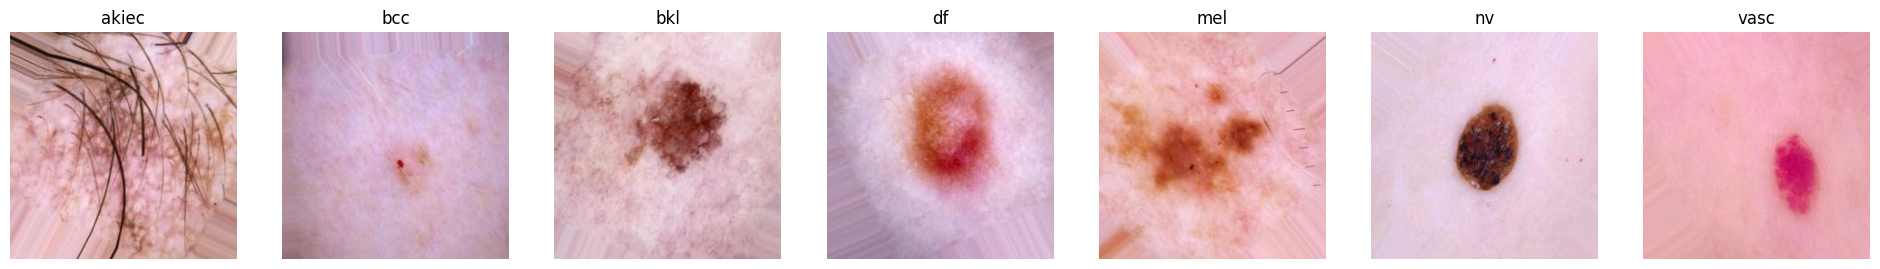

In [ ]:
# Select four image from each label
samples=[]
for i,row in enumerate(dataset['train']):
  if len(samples) == 7:
    break
  if row['label'] not in [sample['label'] for sample in samples] :
    samples.append(row)

# Display the selected images
fig, ax = plt.subplots(1, len(samples),  figsize=(24, 10))
for i,row in enumerate(samples):
  ax[i].imshow(row['image'])
  ax[i].set_title(id2label[samples[i]['label']])
  ax[i].axis('off')
plt.show()

In [ ]:
# Entries in the dataset loaded
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], id=None)}

In [ ]:
dataset["train"].features["label"]

ClassLabel(names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], id=None)

### Preprocessing the data

In [ ]:

# pre-trained model checkpoint to be used for fine-tuning
model_checkpoint = "microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft"

# batch size for training and evaluation
batch_size = 16

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

In [ ]:
# Here we define 2 separate functions, one for training and one for validation
# This is used to apply some augmentation during the training

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

test_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_test(example_batch):
    """Apply test_transforms across a batch."""
    example_batch["pixel_values"] = [test_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
# split up data into training + validation
splits = dataset["train"].train_test_split(test_size=0.2)
train_ds = splits['train']
val_ds = splits['test']
# testing dataset
test_ds = test_dataset["train"]

In [ ]:
# We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_test)

In [ ]:
# Single image entry
test_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7EFB7BB415A0>,
 'label': 0,
 'pixel_values': tensor([[[ 0.9303,  0.9132,  0.8789,  ...,  1.6495,  1.5468,  1.5639],
          [ 0.9474,  0.9303,  0.9132,  ...,  1.6495,  1.5639,  1.5810],
          [ 0.9988,  0.9817,  0.9646,  ...,  1.6324,  1.5982,  1.5982],
          ...,
          [ 1.9407,  1.9749,  2.0092,  ...,  1.7009,  1.5639,  1.5639],
          [ 1.9407,  1.9578,  1.9749,  ...,  1.7694,  1.7180,  1.7180],
          [ 1.9407,  1.9578,  1.9749,  ...,  1.8037,  1.7523,  1.7523]],
 
         [[ 0.0301,  0.0126, -0.0224,  ...,  0.8354,  0.6954,  0.7129],
          [ 0.0476,  0.0301,  0.0126,  ...,  0.8004,  0.7129,  0.7304],
          [ 0.1001,  0.0826,  0.0651,  ...,  0.7829,  0.7654,  0.7654],
          ...,
          [ 1.2906,  1.3081,  1.3081,  ...,  0.9580,  0.8354,  0.8354],
          [ 1.2906,  1.2731,  1.2731,  ...,  1.0280,  0.9930,  0.9930],
          [ 1.2906,  1.2731,  1.2731,  ...,  1.0280, 

### Training the model

In [ ]:
# Metric for assessing the trained model
metric = load_metric("accuracy")

<ipython-input-20-0940b35cbb2c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
# Load the model using it's configuration file and making the output as per the give classes


model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1536]) in the checkpoint and torch.Size([7, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Congigure the Hyperparameters for the training

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-Lesion-Classification-HAM10000-AH",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=0.5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=12,
    warmup_ratio=0.9,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)



# We also define a `collate_fn`, which will be used to batch examples together.
# Each batch consists of 2 keys, namely `pixel_values` and `labels`.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# The trainer is the final instance ready to be trained for given model
# configurations and input data

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/ALM-AHME/swinv2-large-patch4-window12to16-192to256-22kto1k-ft-finetuned-Lesion-Classification-HAM10000-AH into local empty directory.


In [ ]:
# To remove any folder of the model trained
# !rm -r /content/convnextv2-large-1k-224-finetuned-Lesion-Classification-HAM10000-AH-60-20-20

In [ ]:
# Start the training
train_results = trainer.train()

# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.952700,1.974562,0.171634
2,1.818000,1.742299,0.362795
3,1.504400,1.370717,0.504625
4,1.117300,0.979625,0.630010
5,0.871400,0.747479,0.737924
6,0.863100,0.597826,0.772867
7,0.628000,0.479052,0.821172
8,0.558800,0.351681,0.870504
9,0.563200,0.256397,0.916752
10,0.369300,0.187544,0.945529


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/745M [00:00<?, ?B/s]

Upload file runs/Jul07_22-57-18_7c0779250dad/events.out.tfevents.1688770648.7c0779250dad.2329.0:   0%|        …

To https://huggingface.co/ALM-AHME/swinv2-large-patch4-window12to16-192to256-22kto1k-ft-finetuned-Lesion-Classification-HAM10000-AH
   9f3c687..855d3cf  main -> main

   9f3c687..855d3cf  main -> main

To https://huggingface.co/ALM-AHME/swinv2-large-patch4-window12to16-192to256-22kto1k-ft-finetuned-Lesion-Classification-HAM10000-AH
   855d3cf..af2554f  main -> main

   855d3cf..af2554f  main -> main



***** train metrics *****
  epoch                    =          12.0
  total_flos               = 10013947624GF
  train_loss               =        0.9449
  train_runtime            =    1:24:12.32
  train_samples_per_second =         9.242
  train_steps_per_second   =          0.29


In [ ]:
# We can check with the `evaluate` method that our `Trainer` did reload the
# best model properly (if it was not the last one):

metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       12.0
  eval_accuracy           =     0.9681
  eval_loss               =     0.1143
  eval_runtime            = 0:00:12.11
  eval_samples_per_second =     80.337
  eval_steps_per_second   =      5.037


### Testing on Test Dataset

In [ ]:
# Perform predictions
predictions, labels, metrics_test = trainer.predict(test_ds, metric_key_prefix="predict")
trainer.log_metrics("predict", metrics_test)
#trainer.save_metrics("predict", metrics_test)

***** predict metrics *****
  predict_accuracy           =     0.9665
  predict_loss               =       0.13
  predict_runtime            = 0:15:31.26
  predict_samples_per_second =      1.313
  predict_steps_per_second   =      0.083


In [ ]:
# Perform evaluatoin
metrics_test = trainer.evaluate(test_ds, metric_key_prefix="predict")
trainer.log_metrics("predict", metrics_test)
#trainer.save_metrics("predict", metrics_test)

***** predict metrics *****
  epoch                      =       12.0
  predict_accuracy           =     0.9665
  predict_loss               =       0.13
  predict_runtime            = 0:00:15.30
  predict_samples_per_second =     79.901
  predict_steps_per_second   =      5.031


You can now upload the result of the training to the Hub, just execute this instruction :

In [ ]:
# It allows the Trainer to push the model to the [Hub]
trainer.push_to_hub()

Upload file runs/Jul07_22-57-18_7c0779250dad/events.out.tfevents.1688775803.7c0779250dad.2329.1: 100%|########…

To https://huggingface.co/ALM-AHME/swinv2-large-patch4-window12to16-192to256-22kto1k-ft-finetuned-Lesion-Classification-HAM10000-AH
   af2554f..85c3ded  main -> main

   af2554f..85c3ded  main -> main



'https://huggingface.co/ALM-AHME/swinv2-large-patch4-window12to16-192to256-22kto1k-ft-finetuned-Lesion-Classification-HAM10000-AH/commit/85c3dedb8f1e693f005eccd5fbdde1a86fee8fa6'

The trained model can be loaded using the following commands

```python
from transformers import AutoModelForImageClassification, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("ahmedALM1221/convnextv2-large-1k-224-finetuned-eurosat-50")
model = AutoModelForImageClassification.from_pretrained("ahmedALM1221/convnextv2-large-1k-224-finetuned-eurosat-50")

```

# Compute metrics

In [ ]:
!pip install -q datasets transformers
!pip install accelerate
#!pip install wandb

#load libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
# Import the image processor compatible with the given model architecture
# Import the image processor compatible with the given model architecture
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch
from datasets import load_metric
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import warnings

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 124.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 19.4 MB/s eta 0:00:00


In [ ]:
# Load the Gdrive

from google.colab import drive
drive.mount('/content/drive')

# Load the dataset on test
test_dataset=load_dataset("/content/drive/MyDrive/Skin_Cancer/Augmented-Final/test")

In [ ]:
# pre-trained model checkpoint to be used for fine-tuning
model_checkpoint = "ALM-AHME/swinv2-large-patch4-window12to16-192to256-22kto1k-ft-finetuned-Lesion-Classification-HAM10000-AH"

# batch size for training and evaluation
batch_size = 16

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)


In [ ]:
# Here we define 2 separate functions, one for training and one for validation
# This is used to apply some augmentation during the training

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

test_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_test(example_batch):
    """Apply test_transforms across a batch."""
    example_batch["pixel_values"] = [test_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

# Convert the class labels to an integer id
labels = test_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

In [ ]:
test_ds = test_dataset["train"]
test_ds.set_transform(preprocess_test)

# Metric for assessing the trained model
metric = load_metric("accuracy")


# Load the model using it's configuration file and making the output as per the give classes
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = False, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

# Congigure the Hyperparameters for the training

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-Lesion-Classification-HAM10000-AH-60-20-20",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=0.5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=12,
    warmup_ratio=0.9,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)



# We also define a `collate_fn`, which will be used to batch examples together.
# Each batch consists of 2 keys, namely `pixel_values` and `labels`.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# compute all scores macro and weighted
def evaluation_summary(desc, predictions, true_labels):
    accuracy = accuracy_score(predictions, true_labels)
    precision = precision_score(predictions, true_labels, average='macro')
    recall = recall_score(predictions, true_labels, average='macro')
    f1 = fbeta_score(predictions, true_labels, beta=1, average='macro')
    weighted_precision = precision_score(predictions, true_labels, average='weighted')
    weighted_recall = recall_score(predictions, true_labels, average='weighted')
    weighted_f1 = fbeta_score(predictions, true_labels, beta=1, average='weighted')
    results = {
            "classifier": [desc],
            "accuracy": [round(accuracy,3)],
            "macro_precision": [round(precision,3)],
            "macro_recall": [round(recall,3)],
            "macro_f1": [round(f1,3)],
            "weighted_precision": [round(weighted_precision,3)],
            "weighted_recall": [round(weighted_recall,3)],
            "weighted_f1": [round(weighted_f1,3)]
            }
    return pd.DataFrame.from_dict(results)

<ipython-input-6-c648cc331c03>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
# The trainer is the final instance ready to be trained for given model
# configurations and input data
trainer = Trainer(
    model,
    args,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
# Perform predictions
predictions, labels, metrics_test = trainer.predict(test_ds, metric_key_prefix="predict")
trainer.log_metrics("predict", metrics_test)
#trainer.save_metrics("predict", metrics_test)

***** predict metrics *****
  predict_accuracy           =     0.9665
  predict_loss               =       0.13
  predict_runtime            = 0:00:51.09
  predict_samples_per_second =     23.938
  predict_steps_per_second   =      1.507


<Axes: xlabel='Predicted Labels', ylabel='Actual Labels'>

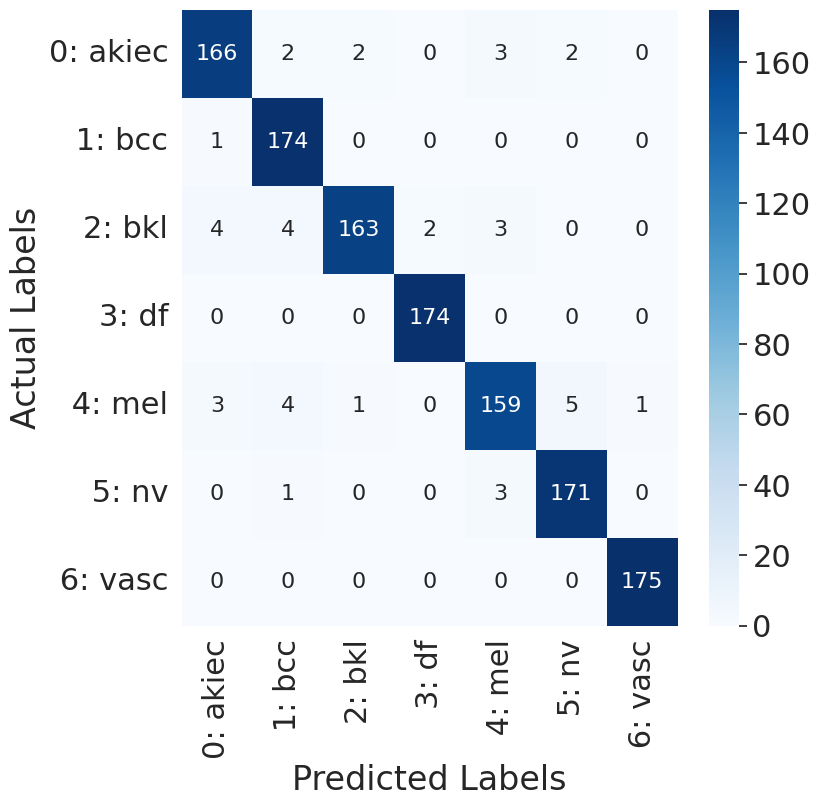

In [ ]:
test_pred_labels=predictions.argmax(axis=1)

data = confusion_matrix(test_ds[:]['label'],test_pred_labels,labels=[0,1,2,3,4,5,6])
df_cm = pd.DataFrame(data, columns=['0: akiec',' 1: bcc', '2: bkl','3: df',' 4: mel',' 5: nv',' 6: vasc'], index = ['0: akiec',' 1: bcc', '2: bkl','3: df',' 4: mel',' 5: nv',' 6: vasc'])
df_cm.index.name = 'Actual Labels'
df_cm.columns.name = 'Predicted Labels'
plt.figure(figsize = (8,8))
sn.set(font_scale=2)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size


In [ ]:
print(classification_report(test_ds[:]['label'],test_pred_labels))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       175
           1       0.94      0.99      0.97       175
           2       0.98      0.93      0.95       176
           3       0.99      1.00      0.99       174
           4       0.95      0.92      0.93       173
           5       0.96      0.98      0.97       175
           6       0.99      1.00      1.00       175

    accuracy                           0.97      1223
   macro avg       0.97      0.97      0.97      1223
weighted avg       0.97      0.97      0.97      1223



In [ ]:
beit_test_result=evaluation_summary("SwinV2-finetuned-Lesion-Classification- Test data", test_pred_labels , test_ds[:]['label'])

summary_eval = pd.concat([beit_test_result], axis=0)
summary_eval = summary_eval.reset_index(drop=True)
color = (summary_eval.weighted_f1 > 0).map({True: 'background-color: green', False: ''})
summary_eval.style.apply(lambda s: color)

,classifier,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
0,SwinV2-finetuned-Lesion-Classification- Test data,0.966000,0.966000,0.967000,0.966000,0.967000,0.966000,0.967000
